In [12]:

import os
os.environ['PYTENSOR_FLAGS'] = 'floatX=float32'
import numpy as np

from pcntoolkit.normative_model.norm_utils import norm_init
from pcntoolkit.util.utils import simulate_data
import matplotlib.pyplot as plt
from pcntoolkit.normative import estimate
from warnings import filterwarnings
filterwarnings('ignore')
import pymc as pm
import pytensor
import cProfile
import timeit

In [15]:


########################### Experiment Settings ###############################


random_state = 29

working_dir = '/home/guus/tmp'  # Specify a working directory to save data and results.

simulation_method = 'linear'
n_features = 1      # The number of input features of X
n_grps = 10          # Number of batches in data
n_samples = 5000     # Number of samples in each group (use a list for different
# sample numbers across different batches)

model_type = 'bspline' #  modelto try 'linear, ''polynomial', 'bspline'   



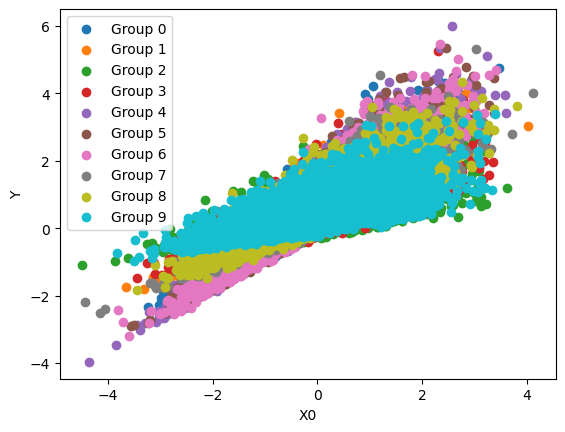

In [16]:


############################## Data Simulation ################################


X_train, Y_train, grp_id_train, X_test, Y_test, grp_id_test, coef = \
    simulate_data(simulation_method, n_samples, n_features, n_grps,
                  working_dir=working_dir, plot=True, noise='heteroscedastic_nongaussian', 
                  random_state=random_state)


In [17]:

################################# Fittig and Predicting ###############################

nm = norm_init(X_train, Y_train, 
               alg='hbr',
               model_type=model_type,
               likelihood='Normal',
               linear_sigma='False',
               random_intercept_mu='True',
               linear_epsilon='False',
               linear_delta='False')


In [11]:
model = nm.hbr.get_model(X_train, Y_train, grp_id_train)

In [6]:
logp_profile = model.profile(model.logp())

with open('logp_profile.txt', 'wt') as a:
    logp_profile.summary(a)


In [7]:

grad_profile = model.profile(pm.gradient(model.logp())) 

with open('grad_profile.txt', 'wt') as a:
    grad_profile.summary(a)

In [8]:
print(type(model.logp()))

<class 'pytensor.tensor.variable.TensorVariable'>


In [9]:
pytensor.printing.pydotprint(model.logp(), outfile="model_logp.png", var_with_name_simple=True)

The output file is available at model_logp.png


In [53]:
a = np.random.randn(50,50)
timeit.timeit(lambda : a.reshape(-1), number=1000000)


0.30615136500273366

In [34]:
timeit.timeit(lambda : np.reshape(a, -1), number=1000000)


2.054333816999133

In [10]:
np.reshape(a, -1)

array([ 0.17341095, -0.2507605 ,  2.1881623 , ...,  0.78394736,
        0.21933634, -0.60980084])